In [ ]:
"""
Purpose: To build an algorithm that calculates the size of the largest 
cluster after site percolation and/or bond percolation (where they are deleted from the network)

"""

In [ ]:
"""
Pseudocode: 
1) Start with empty network. Number of clusters, c = 0, currently in network
Choose at random the order in which vertices will be added to the network

--> if want to remove the highest degree nodes first then order in terms of increasing order of degree
(though should randomly shuffle those with the same degree)

2) Add the next vertex in list to the network initially with no edges
- increase the cluster count by 1 (because the new vertex is initially a cluster of its own)
- Make the cluster size of one
3) Go through the edges attached to newly added vertex and add the edges where the other 
vertex already exists in the network
4) For each edge added, check if the vertices have the same cluster group number:
- if yes then do nothing
- if no, relabel the smaller cluster the same cluster number as the bigger cluster number
- update the sizes of the 2 clusters from which formed
5) Repeat step 2 until all vertices are added

Run these iterations many times to get an average of the S_r

"""

In [1]:
import networkx as nx
import numpy as np

In [5]:
def _get_vertex_order(G,selection_type="random"):
    if selection_type == "random":
        return np.random.permutation(list(G.nodes))
    elif selection_type == "degree":
        """ Will organize from highest to lowest degree"""
        degree_dict = dict()
        for k,v in G.degree():
            if v not in degree_dict.keys():
                degree_dict[v] = [k]
            else:
                degree_dict[v].append(k)
        degree_dict

        #get the order of degree
        order_degrees = np.sort(list(degree_dict.keys()))

        node_order = []
        for k in order_degrees:
            node_order += list(np.random.permutation(degree_dict[k]))

        return node_order
    else:
        raise Exception("Invalid Selection Type")
    
    


In [19]:
from tqdm import tqdm

def run_site_percolation(G,vertex_order_type="random",n_iterations=1000):
    total_runs = []

    for y in tqdm(range(0,n_iterations)):
        current_run_results = [0,1]
        """
        1) Start with empty network. Number of clusters, c = 0, currently in network
        Choose at random the order in which vertices will be added to the network
        """

        clusters=dict() #starting out the clusters list as empyt
        vertex_order = _get_vertex_order(G,vertex_order_type)


        """
        2) Add the next vertex in list to the network initially with no edges
        """
        vertex_labels = dict()
        for i,v in enumerate(vertex_order):
            #print(f"Working on vertex {v}")

            """ 2b)
            - increase the cluster count by 1 (because the new vertex is initially a cluster of its own)
            - Make the cluster size of one

            """

            try:
                max_index_plus_1 = np.max(list(clusters.keys())) + 1
                clusters[max_index_plus_1] = 1
                vertex_labels[v] = max_index_plus_1
            except:
                clusters[0] = 1
                vertex_labels[v] = 0
                continue

            """
            3) Go through the edges attached to newly added vertex and add the edges where the other 
            vertex already exists in the network

            4) For each edge added, check if the vertices have the same cluster group number:
            - if yes then do nothing
            - if no, relabel the smaller cluster the same cluster number as the bigger cluster number
            - update the sizes of the 2 clusters from which formed
            """
            already_added_v = set(vertex_order[:i]).intersection(set(G[v].keys()))
            for a_v in already_added_v:
                if vertex_labels[a_v] != vertex_labels[v]:
                    index_max = np.argmax([clusters[vertex_labels[a_v]],clusters[vertex_labels[v]]])
                    if index_max == 0: #need to change all the labels with v
                        replaced_cluster = vertex_labels[v]
                        indexes_to_change = [jj for jj in vertex_labels.keys() if vertex_labels[jj] == vertex_labels[v]]
                        final_cluster = vertex_labels[a_v]
                    else:
                        replaced_cluster = vertex_labels[a_v]
                        indexes_to_change = [jj for jj in vertex_labels.keys() if vertex_labels[jj] == vertex_labels[a_v]]
                        final_cluster = vertex_labels[v]

                    #change the labels
                    for vv in indexes_to_change:
                        vertex_labels[vv] = final_cluster

                    replaced_size = clusters.pop(replaced_cluster)
                    clusters[final_cluster] += replaced_size

            current_run_results.append(np.max([v for v in clusters.values()]))


            #Done adding that vertex and will continue on to next vertex
            #print(f"clusters = {clusters}")

            total_runs.append(current_run_results)
    total_runs = np.array(total_runs)
    
    from scipy.special import comb
    n = len(G.nodes)
    S_r = np.mean(total_runs,axis=0)
    #calculate s_phi : average largest cluster size as a functin of the occupancy probability
    phi = np.arange(0,1.05,0.05)
    r = np.arange(0,n+1,1)
    s_phi = [np.sum([comb(n, r_curr, exact=True)*(phi_curr**r_curr)*((1-phi_curr)**(n- r_curr))*S_r_curr
                        for r_curr,S_r_curr in zip(r,S_r)]) for phi_curr in phi]
    s_phi = np.array(s_phi)/n
    
    return s_phi,phi
    
    

# Erdos-Renyi Random Percolation

In [ ]:
# Start with a beginning network
G = nx.erdos_renyi_graph(n=1000,p=0.4)
s_phi,phi = run_site_percolation(G,"random",100)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(phi,s_phi)
plt.xlabel("Node occupancy probability")
plt.ylabel("Size of largest cluster")

# Erdos-Renyi : Highest Degree Percolation

In [ ]:
# Start with a beginning network
G = nx.erdos_renyi_graph(n=100,p=0.4)
s_phi_erd_deg,phi_erd_deg = run_site_percolation(G,"degree",1000)


%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(phi,s_phi,label="random")
plt.plot(phi_erd_deg,s_phi_erd_deg,label="degree")

plt.xlabel("Node occupancy probability")
plt.ylabel("Size of largest cluster")
plt.title("Erdos Renyi: Highest Degree Percolation")
plt.legend()

# Small-World: Random Percolation

In [ ]:
# Start with a beginning network
# Start with a beginning network
G = nx.random_graphs.watts_strogatz_graph(n=100,p=0.1,k=20)
s_phi_small_random,phi_small_random= run_site_percolation(G,"random",1000)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(phi_small_random,s_phi_small_random)
plt.xlabel("Node occupancy probability")
plt.ylabel("Size of largest cluster")
plt.title("Small-World: Random Percolation")

# Small-World: Highest Degree Percolation

In [ ]:
# Start with a beginning network
# Start with a beginning network
G = nx.random_graphs.watts_strogatz_graph(n=100,p=0.4,k=10)
s_phi_small_degree,phi_small_degree= run_site_percolation(G,"degree",1000)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(phi_small_random,s_phi_small_random,label="random")
plt.plot(phi_small_degree,s_phi_small_degree,label="degree")
plt.xlabel("Node occupancy probability")
plt.ylabel("Size of largest cluster")
plt.title("Small-World: Highest Degree Percolation")
plt.legend()

# Graphing them all-together

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(phi_small_random,s_phi_small_random,label="small_random")
plt.plot(phi_small_degree,s_phi_small_degree,label="sma__degree")
plt.plot(phi,s_phi,label="erdo_random")
plt.plot(phi_erd_deg,s_phi_erd_deg,label="erdo_degree")

plt.xlabel("Node occupancy probability")
plt.ylabel("Size of largest cluster")
plt.title("Small-World: Highest Degree Percolation")
plt.legend()

In [ ]:
G = nx.barabasi_albert_graph(100,3)
s_phi_barabasi_rand,phi_barabasi_rand= run_site_percolation(G,"random",1000)
s_phi_barabasi_degree,phi_barabasi_degree= run_site_percolation(G,"degree",1000)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(phi_barabasi_rand,s_phi_barabasi_rand,label="random")
plt.plot(phi_barabasi_degree,s_phi_barabasi_degree,label="degree")
plt.xlabel("Node occupancy probability")
plt.ylabel("Size of largest cluster")
plt.title("barabasi_albert_graph random and degree percolation")
plt.legend()

In [ ]:
nx.draw(G)

20

1


20

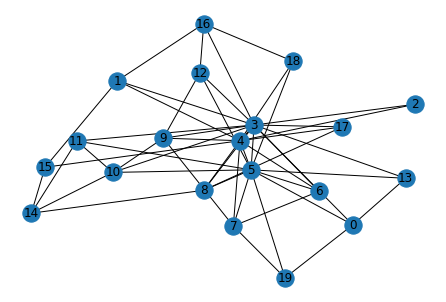

In [11]:
G = nx.barabasi_albert_graph(100,3)
sub_G = G.subgraph(list(range(0,20)))
print(nx.number_connected_components(sub_G))
nx.draw(sub_G,with_labels=True)
Gcc = sorted(nx.connected_components(sub_G), key=len, reverse=True)
len(Gcc[0])
#G0 = G.subgraph(Gcc[0])


# Using a Naive Percolation Algorithm to try the same thing to test the results

In [4]:
np.random.binomial(10,0.1)

1

In [20]:
s_phi_naive_barabasi_rand

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [29]:
sorted(nx.connected_components(sub_G), key=len, reverse=True)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}]

100%|██████████| 1000/1000 [00:14<00:00, 69.53it/s]


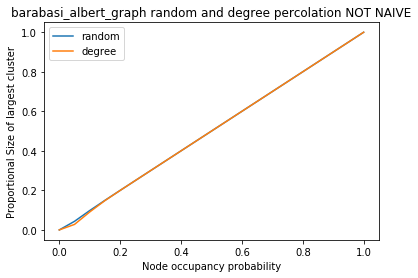

In [35]:
from tqdm import tqdm

def largest_connected_component_size(current_graph,**kwargs):
    Gcc = sorted(nx.connected_components(current_graph), key=len, reverse=True)
    #print(f"Gcc = {Gcc}")
    if len(Gcc) > 0:
        #print(f"len(Gcc[0]) = " + str(len(Gcc[0])))
        return len(Gcc[0])
    else:
        return 0

#largest_connected_component_size(sub_G)

def naive_site_percolation(G,vertex_order_type,n_iterations=1000):
    """
    Purpose: To test whether a naive implementation matches the 
    optimized version built
    
    1) Get random subset of nodes using probability phi to get the number of nodes to keep
    2) Extract the subgraph for those nodes
    3) Find the largest component of that graph
    4) Store that size for that phi and continue till all the phis are done
    5) Repeat for a certain number of iterations
    
    """
    
    n = len(G.nodes)
    phi = np.arange(0,1.05,0.05)
    s_phi_total = []
    for i in tqdm(range(0,n_iterations)):
        #get random subsetof nodes
        s_phi_current= []
        for phi_curr in phi:
            #print(f"phi_curr = " + str(phi_curr))
            n_nodes_to_pick = np.random.binomial(n,phi_curr)
            #print(f"n_nodes_to_pick = {n_nodes_to_pick}")
            subgraph_nodes = _get_vertex_order(G,selection_type=vertex_order_type)[:n_nodes_to_pick]
            #print(f"subgraph_nodes = {subgraph_nodes}")
            largest_component_size = largest_connected_component_size(G.subgraph(subgraph_nodes))
            #print(f"largest_component_size = {largest_component_size}")
            s_phi_current.append(largest_component_size)
        s_phi_total.append(s_phi_current)
    
    #now need to average over all of the trials
    s_phi = np.mean(s_phi_total,axis=0)
    s_phi = np.array(s_phi)/n
    
    return s_phi,phi

G = nx.barabasi_albert_graph(100,3)
G = nx.erdos_renyi_graph(100,0.4)

s_phi_naive_barabasi_rand, phi_naive_barabasi_rand = naive_site_percolation(G,
                                                        vertex_order_type="random",
                                                        n_iterations = 1000)
s_phi_naive_barabasi_degree, phi_naive_barabasi_degree = naive_site_percolation(G,
                                                        vertex_order_type="degree",
                                                        n_iterations = 1000)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(phi_naive_barabasi_rand,s_phi_naive_barabasi_rand,label="random")
plt.plot(phi_naive_barabasi_degree,s_phi_naive_barabasi_degree,label="degree")
plt.xlabel("Node occupancy probability")
plt.ylabel("Proportional Size of largest cluster")
plt.title("barabasi_albert_graph random and degree percolation NAIVE ONE")
plt.legend()


s_phi_barabasi_rand,phi_barabasi_rand= run_site_percolation(G,"random",1000)
s_phi_barabasi_degree,phi_barabasi_degree= run_site_percolation(G,"degree",1000)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(phi_barabasi_rand,s_phi_barabasi_rand,label="random")
plt.plot(phi_barabasi_degree,s_phi_barabasi_degree,label="degree")
plt.xlabel("Node occupancy probability")
plt.ylabel("Proportional Size of largest cluster")
plt.title("barabasi_albert_graph random and degree percolation NOT NAIVE")
plt.legend()


            
        
        
    
    

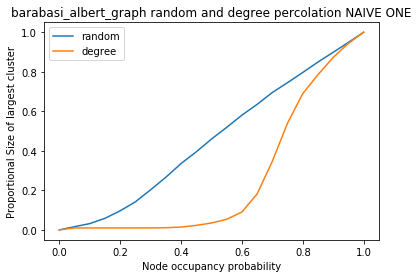

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(phi_naive_barabasi_rand,s_phi_naive_barabasi_rand,label="random")
plt.plot(phi_naive_barabasi_degree,s_phi_naive_barabasi_degree,label="degree")
plt.xlabel("Node occupancy probability")
plt.ylabel("Proportional Size of largest cluster")
plt.title("barabasi_albert_graph random and degree percolation NAIVE ONE")
plt.legend()

In [ ]:
"""
Conclusion: The new algorithm works the same as the naive but also works faster

"""